# Deep mutual learning setting

In [1]:
import numpy as np
import cv2
from scipy import misc
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
from IPython.display import HTML
import os
import medpy
from medpy.io import load
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from math import ceil

from utils.preprocessing import preprocessing_flownet, preprocessing_pwc
from utils.load_models import load_flownet2, load_pwcnet, init_weights
from utils.plotting import flow2img, overlaySegment, showFlow
from utils.layers import warp, warpImage #, correlation_layer, meanfield
from utils.encoding import labelMatrixOneHot, dice_coeff


from models.pdd_net.pdd_student import OBELISK2d, deeds2d

/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3890: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


# Data
Load data and split into train test

In [2]:
imgs = torch.load('Data/img.pth')
segs = torch.load('Data/seg.pth')

H,W = imgs[0].shape

#define a training split 
torch.manual_seed(10)
# Now, we prepare our train & test dataset.
test_set = torch.LongTensor([35, 41, 0, 4, 39])
train_set = torch.arange(43)
for idx in test_set:
    train_set = train_set[train_set != idx]
print("Train: ", train_set)
print("Test: ", test_set)

Train:  tensor([ 1,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
        20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38,
        40, 42])
Test:  tensor([35, 41,  0,  4, 39])


## FlowNet2 as teacher Network

In [3]:
flow2 = load_flownet2().cuda()

## Student creation

In [4]:
disp_hw = 5
displace_range = 11

o_m = H//4
o_n = W//4
ogrid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,o_m,o_n)).view(1,1,-1,2).cuda()
disp_range = 0.25
displacement_width = 15    
shift_xy = F.affine_grid(disp_range*torch.eye(2,3).unsqueeze(0),(1,1,displacement_width,displacement_width)).view(1,1,-1,2).cuda()
grid_size = 32#25#30
grid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,grid_size,grid_size)).view(1,-1,1,2).cuda()

In [17]:
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d) or isinstance(m, nn.Conv1d):
        nn.init.xavier_normal(m.weight)
        if m.bias is not None:
            nn.init.constant(m.bias, 0.0)

class OBELISK2d(nn.Module):
    def __init__(self, chan = 16):

        super(OBELISK2d, self).__init__()
        channels = chan
        self.offsets = nn.Parameter(torch.randn(2,channels *2,2) *0.05)
        self.layer0 = nn.Conv2d(1, 4, 5, stride=2, bias=False, padding=2)
        self.batch0 = nn.BatchNorm2d(4)

        self.layer1 = nn.Conv2d(channels *8, channels *4, 1, bias=False, groups=1)
        self.batch1 = nn.BatchNorm2d(channels *4)
        self.layer2 = nn.Conv2d(channels *4, channels *4, 3, bias=False, padding=1)
        self.batch2 = nn.BatchNorm2d(channels *4)
        self.layer3 = nn.Conv2d(channels *4, channels *1, 1)
        

    def forward(self, input_img):
        img_in = F.avg_pool2d(input_img ,3 ,padding=1 ,stride=2)
        img_in = F.relu(self.batch0(self.layer0(img_in)))
        
        sampled = F.grid_sample(img_in ,ogrid_xy + self.offsets[0 ,:,:].view(1 ,-1 ,1 ,2)).view(1 ,-1 ,o_m ,o_n)
        sampled -= F.grid_sample(img_in ,ogrid_xy + self.offsets[1 ,:,:].view(1 ,-1 ,1 ,2)).view(1 ,-1 ,o_m ,o_n)

        x = F.relu(self.batch1(self.layer1(sampled)))
        x = F.relu(self.batch2(self.layer2(x)))
        features = self.layer3(x)
        return features

In [18]:
seq = torch.nn.Sequential(torch.nn.Conv2d(1,32,kernel_size=5,stride=2,padding=4,dilation=2),
                          torch.nn.BatchNorm2d(32),
                          torch.nn.PReLU(),
                          torch.nn.Conv2d(32,32,kernel_size=3,stride=1,padding=1,dilation=1),
                          torch.nn.BatchNorm2d(32),
                          torch.nn.PReLU(),
                          torch.nn.Conv2d(32,64,kernel_size=3,stride=2,padding=1,dilation=1),
                          torch.nn.BatchNorm2d(64),
                          torch.nn.PReLU(),
                          torch.nn.Conv2d(64,16,kernel_size=1,stride=1,padding=0,dilation=1),
                          torch.nn.Sigmoid())

In [19]:
def min_convolution(ssd_distance, displace_range, H, W):
    # Prepare operators for smooth dense displacement space
    pad1 = nn.ReplicationPad2d(5)
    avg1 = nn.AvgPool2d(5,stride=1)
    max1 = nn.MaxPool2d(3,stride=1)
    pad2 = nn.ReplicationPad2d(6)
    # approximate min convolution / displacement compatibility

    ssd_minconv = avg1(avg1(-max1(-pad1(ssd_distance.permute(0,2,3,1).reshape(1,-1,displace_range,displace_range)))))

    ssd_minconv = ssd_minconv.permute(0,2,3,1).view(1,-1,H,W)
    min_conv_cost = avg1(avg1(avg1(pad2(ssd_minconv))))
    
    return min_conv_cost

def meanfield(ssd_distance,img_fixed,displace_range,H,W):

    crnt_dev = ssd_distance.device

    cost = min_convolution(ssd_distance, displace_range, H, W)

    soft_cost = F.softmax(-10*cost.view(displace_range**2,-1).t(),1)
    
    disp_hw = (displace_range-1)//2
    disp_mesh_grid = disp_hw*F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,displace_range,displace_range),align_corners=True)
    disp_mesh_grid /= torch.Tensor([(W-1)*.5,(H-1)*.5])

    disp_xy = torch.sum(soft_cost.view(1,H,W,-1,1)*disp_mesh_grid.view(1,1,1,-1,2).to(crnt_dev),3).permute(0,3,1,2) 
    

    return soft_cost,disp_xy

def correlation_layer(displace_range, feat_moving, feat_fixed):
    
    disp_hw = (displace_range-1)//2
    feat_moving_unfold = F.unfold(feat_moving.transpose(1,0),(displace_range,displace_range),padding=disp_hw)
    B,C,H,W = feat_fixed.size()
    
    ssd_distance = ((feat_moving_unfold-feat_fixed.view(C,1,-1))**2).sum(0).view(1,displace_range**2,H,W)

    return ssd_distance#.detach()

# initalize the sequential


# 3.1 DML with two instances

train for 100 epochs with two optimizers. The loss is calculated between predictions of the two students and teacher output

## Obelisk

In [20]:
student_one = OBELISK2d(16)
init_weights(student_one)
student_one.train().cuda()

optimizer_student_one = torch.optim.Adam(list(student_one.parameters()), lr=0.00025)


student_two = OBELISK2d(16)
init_weights(student_two)
student_two.train().cuda()

optimizer_student_two = torch.optim.Adam(list(student_two.parameters()), lr=0.00025)

students = [student_one, student_two]
optims = [optimizer_student_one, optimizer_student_two]

epochs = 1
grad_accum = 5
displace_range = 11

for epoch in range(epochs):
    # get training examples
    rnd_train_idx = torch.randperm(train_set.size(0))
    p_fix = train_set[rnd_train_idx[0]]
    p_mov = train_set[rnd_train_idx[1]]

    fixed = imgs[p_fix:p_fix+1,:,:].unsqueeze(1).float() / 255
    moving = imgs[p_mov:p_mov+1,:,:].unsqueeze(1).float() / 255
    
    fixed_seg = segs[p_fix:p_fix+1,:,:].long().contiguous()
    moving_seg = segs[p_mov:p_mov+1,:,:].long().contiguous()
    
    # get the teacher output
    flow_in = preprocessing_flownet(fixed.reshape(H,W,1),moving.reshape(H,W,1)).cuda()
    teacher_flow = flow2(flow_in)
    teacher_flow = F.interpolate(teacher_flow, size=(H//4,W//4), mode='bilinear')
    
        
    feat_one_fixed = student_one(fixed.cuda())
    feat_one_moving = student_one(moving.cuda())
    
    feat_two_fixed = student_two(fixed.cuda())
    feat_two_moving = student_two(moving.cuda())
    
    ssd_distance_one = correlation_layer(displace_range, feat_one_moving, feat_one_fixed)
    soft_cost_one,disp_xy_one = meanfield(ssd_distance_one, fixed, displace_range, H//4, W//4)
        
    ssd_distance_two = correlation_layer(displace_range, feat_two_moving, feat_two_fixed)
    soft_cost_two,disp_xy_two = meanfield(ssd_distance_two, fixed, displace_range, H//4, W//4)
    
    loss_one = 0
    loss_two = 0
    
    student_diff = torch.sum(torch.pow(disp_xy_one - disp_xy_two, 2)) 
    
    loss_one += student_diff
    loss_two += student_diff
    
    loss_one += torch.sum(torch.pow(teacher_flow - disp_xy_one, 2))
    loss_two += torch.sum(torch.pow(teacher_flow - disp_xy_two, 2))
    
    loss_one.backward(retain_graph=True)
    loss_two.backward()
    
    if (epoch+1)%grad_accum == 0:
        # every grad_accum iterations : backpropagate the accumulated gradients
        optimizer_student_one.step()
        optimizer_student_one.zero_grad()
        
        optimizer_student_two.step()
        optimizer_student_two.zero_grad()

torch.Size([1, 6, 320, 256])


PDD-Student 1:  tensor([0.7832, 0.5520, 0.2612, 0.0000, 0.8481, 0.4397, 0.2098, 0.0000]) tensor(0.3868)
PDD-Student 2:  tensor([0.4225, 0.4870, 0.0355, 0.0000, 0.7213, 0.1846, 0.0012, 0.0000]) tensor(0.2315)
Teacher:  tensor([0.4831, 0.6269, 0.4405, 0.0000, 0.8581, 0.7310, 0.3541, 0.4265]) tensor(0.4900)
diff fixed, moving:  tensor([0.5716, 0.5846, 0.0000, 0.0000, 0.7629, 0.7030, 0.3036, 0.3106]) tensor(0.4045)


/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


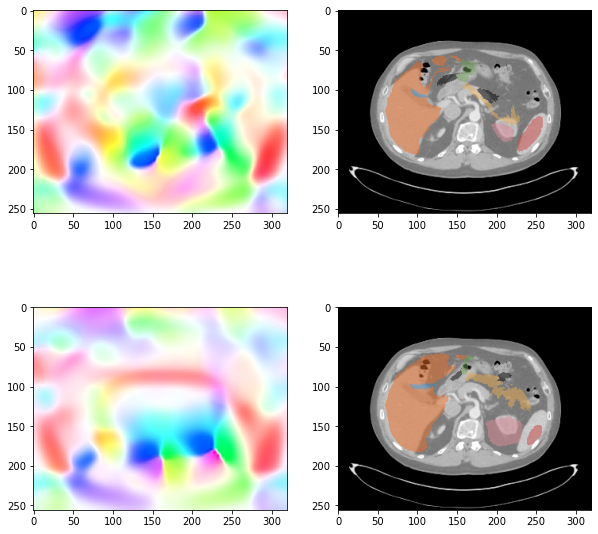

In [10]:
student_one.eval()
student_two.eval()

rnd_test_idx = torch.randperm(test_set.size(0))
p_fix = test_set[rnd_test_idx[0]]
p_mov = test_set[rnd_test_idx[1]]

fixed = imgs[p_fix:p_fix+1,:,:].unsqueeze(1).float() / 255
moving = imgs[p_mov:p_mov+1,:,:].unsqueeze(1).float() / 255

fixed_seg = segs[p_fix:p_fix+1,:,:].long().contiguous()
moving_seg = segs[p_mov:p_mov+1,:,:].long().contiguous()

flow_in = preprocessing_flownet(fixed.reshape(H,W,1),moving.reshape(H,W,1)).cuda()
teacher_flow = flow2(flow_in)

with torch.no_grad():
    fixed_feat_one = student_one(fixed.cuda())
    moving_feat_one = student_one(moving.cuda())

    fixed_feat_two = student_two(fixed.cuda())
    moving_feat_two = student_two(moving.cuda())

ssd_distance_one = correlation_layer(displace_range, moving_feat_one, fixed_feat_one).contiguous()
#regularise using meanfield inference with approx. min-convolutions
soft_cost_one,disp_xy_one = meanfield(ssd_distance_one, fixed, displace_range, H//4, W//4)
#upsample field to original resolution
dense_flow_fit_one = F.interpolate(disp_xy_one,scale_factor=4,mode='bicubic')

ssd_distance_two = correlation_layer(displace_range, moving_feat_two, fixed_feat_two).contiguous()
#regularise using meanfield inference with approx. min-convolutions
soft_cost_two,disp_xy_two = meanfield(ssd_distance_two, fixed, displace_range, H//4, W//4)
#upsample field to original resolution
dense_flow_fit_two = F.interpolate(disp_xy_two,scale_factor=4,mode='bicubic')

#apply and evaluate transformation
identity = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,H,W),align_corners=False).cuda()
warped_student_seg_one = F.grid_sample(moving_seg.cuda().float().unsqueeze(1),identity+dense_flow_fit_one.permute(0,2,3,1),mode='nearest',align_corners=False).cpu()
warped_student_seg_two = F.grid_sample(moving_seg.cuda().float().unsqueeze(1),identity+dense_flow_fit_two.permute(0,2,3,1),mode='nearest',align_corners=False).cpu()

#warped_teacher_seg = F.grid_sample(moving_seg.cuda().float().unsqueeze(1),identity+teacher_flow.permute(0,2,3,1),mode='nearest',align_corners=False).cpu()
warped_teacher_seg = warp(moving_seg.unsqueeze(0).float().cuda(),teacher_flow.squeeze().cuda()).cpu()
#warped_teacher_seg = warpImage(moving_seg.unsqueeze(0).float().cuda(), teacher_flow.cuda()).cpu()

d1 = dice_coeff(fixed_seg,warped_student_seg_one.squeeze(),9)
print("PDD-Student 1: ", d1,d1.mean())
d2 = dice_coeff(fixed_seg,warped_student_seg_two.squeeze(),9)
print("PDD-Student 2: ", d2,d2.mean())
d3 = dice_coeff(fixed_seg,warped_teacher_seg.squeeze(),9)
print("Teacher: ", d3, d3.mean())
d4 = dice_coeff(fixed_seg,moving_seg,9)
print("diff fixed, moving: ", d4, d4.mean())

rgb_one = showFlow(dense_flow_fit_one.cpu().transpose(-2,-1).flip(1))
overlay_one = overlaySegment(fixed.squeeze().t().flip(0),warped_student_seg_one.data.squeeze().t().flip(0),False)

rgb_two = showFlow(dense_flow_fit_two.cpu().transpose(-2,-1).flip(1))
overlay_two = overlaySegment(fixed.squeeze().t().flip(0),warped_student_seg_two.data.squeeze().t().flip(0),False)


fig = plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(rgb_one)
plt.subplot(222)
plt.imshow(overlay_one)
plt.subplot(223)
plt.imshow(rgb_two)
plt.subplot(224)
plt.imshow(overlay_two)

## Seq

In [11]:
student_one = torch.nn.Sequential(torch.nn.Conv2d(1,32,kernel_size=5,stride=2,padding=4,dilation=2),
                          torch.nn.BatchNorm2d(32),
                          torch.nn.PReLU(),
                          torch.nn.Conv2d(32,32,kernel_size=3,stride=1,padding=1,dilation=1),
                          torch.nn.BatchNorm2d(32),
                          torch.nn.PReLU(),
                          torch.nn.Conv2d(32,64,kernel_size=3,stride=2,padding=1,dilation=1),
                          torch.nn.BatchNorm2d(64),
                          torch.nn.PReLU(),
                          torch.nn.Conv2d(64,16,kernel_size=1,stride=1,padding=0,dilation=1),
                          torch.nn.Sigmoid())
student_one.train().cuda()

optimizer_student_one = torch.optim.Adam(list(student_one.parameters()), lr=0.00025)


student_two = torch.nn.Sequential(torch.nn.Conv2d(1,32,kernel_size=5,stride=2,padding=4,dilation=2),
                          torch.nn.BatchNorm2d(32),
                          torch.nn.PReLU(),
                          torch.nn.Conv2d(32,32,kernel_size=3,stride=1,padding=1,dilation=1),
                          torch.nn.BatchNorm2d(32),
                          torch.nn.PReLU(),
                          torch.nn.Conv2d(32,64,kernel_size=3,stride=2,padding=1,dilation=1),
                          torch.nn.BatchNorm2d(64),
                          torch.nn.PReLU(),
                          torch.nn.Conv2d(64,16,kernel_size=1,stride=1,padding=0,dilation=1),
                          torch.nn.Sigmoid())
student_two.train().cuda()

optimizer_student_two = torch.optim.Adam(list(student_two.parameters()), lr=0.00025)

students = [student_one, student_two]
optims = [optimizer_student_one, optimizer_student_two]

epochs = 100
grad_accum = 5
displace_range = 11

for epoch in range(epochs):
    # get training examples
    rnd_train_idx = torch.randperm(train_set.size(0))
    p_fix = train_set[rnd_train_idx[0]]
    p_mov = train_set[rnd_train_idx[1]]

    fixed = imgs[p_fix:p_fix+1,:,:].unsqueeze(1).float() / 255
    moving = imgs[p_mov:p_mov+1,:,:].unsqueeze(1).float() / 255
    
    fixed_seg = segs[p_fix:p_fix+1,:,:].long().contiguous()
    moving_seg = segs[p_mov:p_mov+1,:,:].long().contiguous()
    
    # get the teacher output
    flow_in = preprocessing_flownet(fixed.reshape(H,W,1),moving.reshape(H,W,1)).cuda()
    teacher_flow = flow2(flow_in)
    teacher_flow = F.interpolate(teacher_flow, size=(H//4,W//4), mode='bilinear')
    
        
    feat_one_fixed = student_one(fixed.cuda())
    feat_one_moving = student_one(moving.cuda())
    
    feat_two_fixed = student_two(fixed.cuda())
    feat_two_moving = student_two(moving.cuda())
    
    ssd_distance_one = correlation_layer(displace_range, feat_one_moving, feat_one_fixed)
    # compute the MIN-convolution & probabilistic output with the given function
    soft_cost_one,disp_xy_one = meanfield(ssd_distance_one, fixed, displace_range, H//4, W//4)
        
    ssd_distance_two = correlation_layer(displace_range, feat_two_moving, feat_two_fixed)
    # compute the MIN-convolution & probabilistic output with the given function
    soft_cost_two,disp_xy_two = meanfield(ssd_distance_two, fixed, displace_range, H//4, W//4)
    
    loss_one = 0
    loss_two = 0
    
    student_diff = torch.sum(torch.pow(disp_xy_one - disp_xy_two, 2)) 
    
    loss_one += student_diff
    loss_two += student_diff
    
    loss_one += torch.sum(torch.pow(teacher_flow - disp_xy_one, 2))
    loss_two += torch.sum(torch.pow(teacher_flow - disp_xy_two, 2))
    
    loss_one.backward(retain_graph=True)
    loss_two.backward()
    
    if (epoch+1)%grad_accum == 0:
        # every grad_accum iterations : backpropagate the accumulated gradients
        optimizer_student_one.step()
        optimizer_student_one.zero_grad()
        
        optimizer_student_two.step()
        optimizer_student_two.zero_grad()

Student 1:  tensor([0.3138, 0.5872, 0.0000, 0.0000, 0.7786, 0.0835, 0.3628, 0.0000]) tensor(0.2657)
Student 2:  tensor([0.3270, 0.5890, 0.0000, 0.0000, 0.7638, 0.0141, 0.3642, 0.0000]) tensor(0.2572)
Teacher:  tensor([0.3261, 0.6905, 0.0000, 0.0000, 0.7683, 0.0701, 0.3683, 0.0000]) tensor(0.2779)
diff fixed, moving:  tensor([0.2874, 0.5855, 0.0000, 0.0000, 0.7682, 0.0329, 0.4257, 0.0000]) tensor(0.2625)


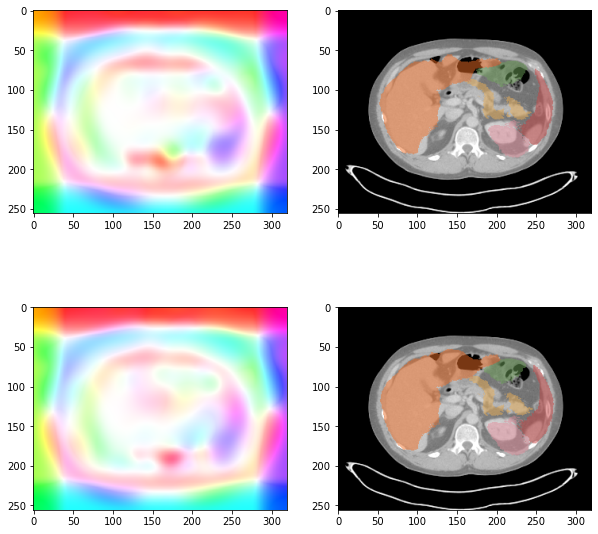

In [12]:
student_one.eval()
student_two.eval()

rnd_test_idx = torch.randperm(test_set.size(0))
p_fix = test_set[rnd_test_idx[0]]
p_mov = test_set[rnd_test_idx[1]]

fixed = imgs[p_fix:p_fix+1,:,:].unsqueeze(1).float() / 255
moving = imgs[p_mov:p_mov+1,:,:].unsqueeze(1).float() / 255

fixed_seg = segs[p_fix:p_fix+1,:,:].long().contiguous()
moving_seg = segs[p_mov:p_mov+1,:,:].long().contiguous()

flow_in = preprocessing_flownet(fixed.reshape(H,W,1),moving.reshape(H,W,1)).cuda()
teacher_flow = flow2(flow_in)

with torch.no_grad():
    fixed_feat_one = student_one(fixed.cuda())
    moving_feat_one = student_one(moving.cuda())

    fixed_feat_two = student_two(fixed.cuda())
    moving_feat_two = student_two(moving.cuda())

ssd_distance_one = correlation_layer(displace_range, moving_feat_one, fixed_feat_one).contiguous()
#regularise using meanfield inference with approx. min-convolutions
soft_cost_one,disp_xy_one = meanfield(ssd_distance_one, fixed, displace_range, H//4, W//4)
#upsample field to original resolution
dense_flow_fit_one = F.interpolate(disp_xy_one,scale_factor=4,mode='bicubic')

ssd_distance_two = correlation_layer(displace_range, moving_feat_two, fixed_feat_two).contiguous()
#regularise using meanfield inference with approx. min-convolutions
soft_cost_two,disp_xy_two = meanfield(ssd_distance_two, fixed, displace_range, H//4, W//4)
#upsample field to original resolution
dense_flow_fit_two = F.interpolate(disp_xy_two,scale_factor=4,mode='bicubic')

#apply and evaluate transformation
identity = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,H,W),align_corners=False).cuda()
warped_student_seg_one = F.grid_sample(moving_seg.cuda().float().unsqueeze(1),identity+dense_flow_fit_one.permute(0,2,3,1),mode='nearest',align_corners=False).cpu()
warped_student_seg_two = F.grid_sample(moving_seg.cuda().float().unsqueeze(1),identity+dense_flow_fit_two.permute(0,2,3,1),mode='nearest',align_corners=False).cpu()

#warped_teacher_seg = F.grid_sample(moving_seg.cuda().float().unsqueeze(1),identity+teacher_flow.permute(0,2,3,1),mode='nearest',align_corners=False).cpu()
warped_teacher_seg = warp(moving_seg.unsqueeze(0).float().cuda(),teacher_flow.squeeze().cuda()).cpu()
#warped_teacher_seg = warpImage(moving_seg.unsqueeze(0).float().cuda(), teacher_flow.cuda()).cpu()

d1 = dice_coeff(fixed_seg,warped_student_seg_one.squeeze(),9)
print("Student 1: ", d1,d1.mean())
d2 = dice_coeff(fixed_seg,warped_student_seg_two.squeeze(),9)
print("Student 2: ", d2,d2.mean())
d3 = dice_coeff(fixed_seg,warped_teacher_seg.squeeze(),9)
print("Teacher: ", d3, d3.mean())
d4 = dice_coeff(fixed_seg,moving_seg,9)
print("diff fixed, moving: ", d4, d4.mean())


rgb_one = showFlow(dense_flow_fit_one.cpu().transpose(-2,-1).flip(1))
overlay_one = overlaySegment(fixed.squeeze().t().flip(0),warped_student_seg_one.data.squeeze().t().flip(0),False)

rgb_two = showFlow(dense_flow_fit_two.cpu().transpose(-2,-1).flip(1))
overlay_two = overlaySegment(fixed.squeeze().t().flip(0),warped_student_seg_two.data.squeeze().t().flip(0),False)

fig = plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(rgb_one)
plt.subplot(222)
plt.imshow(overlay_one)
plt.subplot(223)
plt.imshow(rgb_two)
plt.subplot(224)
plt.imshow(overlay_two)

# 3.2 Combine with labelloss

## Obelisk

In [31]:
student_one = OBELISK2d(16)
init_weights(student_one)
student_one.train().cuda()

optimizer_student_one = torch.optim.Adam(list(student_one.parameters()), lr=0.00025)


student_two = OBELISK2d(16)
init_weights(student_two)
student_two.train().cuda()

optimizer_student_two = torch.optim.Adam(list(student_two.parameters()), lr=0.00025)

students = [student_one, student_two]
optims = [optimizer_student_one, optimizer_student_two]

epochs = 100
grad_accum = 5
displace_range = 11

for epoch in range(epochs):
    # get training examples
    rnd_train_idx = torch.randperm(train_set.size(0))
    p_fix = train_set[rnd_train_idx[0]]
    p_mov = train_set[rnd_train_idx[1]]

    fixed = imgs[p_fix:p_fix+1,:,:].unsqueeze(1).float() / 255
    moving = imgs[p_mov:p_mov+1,:,:].unsqueeze(1).float() / 255
    
    fixed_seg = segs[p_fix:p_fix+1,:,:].long().contiguous()
    moving_seg = segs[p_mov:p_mov+1,:,:].long().contiguous()
    
     # Label onehot and scale to outputsize 
    label_moving = F.one_hot(moving_seg,num_classes=9).permute(0,3,1,2).float()
    _,C1,Hf,Wf = label_moving.size()
    label_moving = F.interpolate(label_moving,size=(H//4,Wf//4),mode='bilinear')
    label_fixed = F.one_hot(fixed_seg,num_classes=9).permute(0,3,1,2).float()
    label_fixed = F.interpolate(label_fixed,size=(Hf//4,Wf//4),mode='bilinear')
    # generate the "unfolded" version of the moving encoding that will result in the shifted versions per channel
    # according to the corresponding discrete displacement pair
    label_moving_unfold = F.unfold(label_moving,(displace_range,displace_range),padding=disp_hw).view(1,9,displace_range**2,-1)
    
    
    # get the teacher output
    flow_in = preprocessing_flownet(fixed.reshape(H,W,1),moving.reshape(H,W,1)).cuda()
    teacher_flow = flow2(flow_in)
    teacher_flow = F.interpolate(teacher_flow, size=(H//4,W//4), mode='bilinear')
    
        
    feat_one_fixed = student_one(fixed.cuda())
    feat_one_moving = student_one(moving.cuda())
    
    feat_two_fixed = student_two(fixed.cuda())
    feat_two_moving = student_two(moving.cuda())
    
    ssd_distance_one = correlation_layer(displace_range, feat_one_moving, feat_one_fixed)
    soft_cost_one,disp_xy_one = meanfield(ssd_distance_one, fixed, displace_range, H//4, W//4)
        
    label_warped_one = torch.sum(soft_cost_one.cpu().t().unsqueeze(0)*label_moving_unfold.squeeze(0),1)

    
    ssd_distance_two = correlation_layer(displace_range, feat_two_moving, feat_two_fixed)
    soft_cost_two,disp_xy_two = meanfield(ssd_distance_two, fixed, displace_range, H//4, W//4)
    
    label_warped_two = torch.sum(soft_cost_two.cpu().t().unsqueeze(0)*label_moving_unfold.squeeze(0),1)

    
    loss_one = 0
    loss_two = 0
    
    #student_diff = torch.sum(torch.pow(disp_xy_one - disp_xy_two, 2)) 
    student_diff = torch.sum(torch.pow(label_warped_two.reshape(9,-1)-label_warped_one.reshape(9,-1),2),0).mean().cuda()
    
    loss_one += student_diff
    loss_two += student_diff
    
    loss_one += torch.sum(torch.pow(label_fixed.reshape(9,-1)-label_warped_one.reshape(9,-1),2),0).mean()
    loss_two += torch.sum(torch.pow(label_fixed.reshape(9,-1)-label_warped_two.reshape(9,-1),2),0).mean()
    
    loss_one += torch.sum(torch.pow(teacher_flow - disp_xy_one, 2))
    loss_two += torch.sum(torch.pow(teacher_flow - disp_xy_two, 2))
    
    loss_one.backward(retain_graph=True)
    loss_two.backward()
    
    if (epoch+1)%grad_accum == 0:
        # every grad_accum iterations : backpropagate the accumulated gradients
        optimizer_student_one.step()
        optimizer_student_one.zero_grad()
        
        optimizer_student_two.step()
        optimizer_student_two.zero_grad()

PDD-Student 1:  tensor([0.7804, 0.8710, 0.7448, 0.0000, 0.8754, 0.6925, 0.0648, 0.0000]) tensor(0.5036)
PDD-Student 2:  tensor([0.4262, 0.6494, 0.5883, 0.0000, 0.8400, 0.6852, 0.3860, 0.0000]) tensor(0.4469)
Teacher:  tensor([0.8371, 0.5572, 0.5653, 0.0000, 0.7421, 0.5798, 0.1545, 0.1481]) tensor(0.4480)
diff fixed, moving:  tensor([0.7520, 0.5698, 0.4853, 0.0000, 0.7033, 0.5935, 0.2492, 0.0987]) tensor(0.4315)


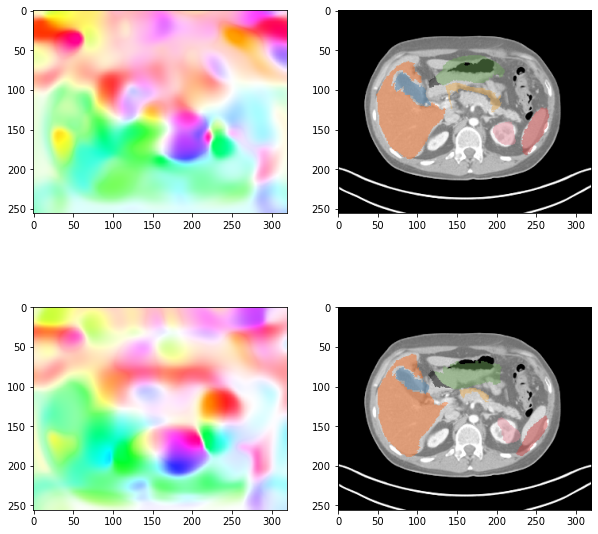

In [32]:
student_one.eval()
student_two.eval()

rnd_test_idx = torch.randperm(test_set.size(0))
p_fix = test_set[rnd_test_idx[0]]
p_mov = test_set[rnd_test_idx[1]]

fixed = imgs[p_fix:p_fix+1,:,:].unsqueeze(1).float() / 255
moving = imgs[p_mov:p_mov+1,:,:].unsqueeze(1).float() / 255

fixed_seg = segs[p_fix:p_fix+1,:,:].long().contiguous()
moving_seg = segs[p_mov:p_mov+1,:,:].long().contiguous()

flow_in = preprocessing_flownet(fixed.reshape(H,W,1),moving.reshape(H,W,1)).cuda()
teacher_flow = flow2(flow_in)

with torch.no_grad():
    fixed_feat_one = student_one(fixed.cuda())
    moving_feat_one = student_one(moving.cuda())

    fixed_feat_two = student_two(fixed.cuda())
    moving_feat_two = student_two(moving.cuda())

ssd_distance_one = correlation_layer(displace_range, moving_feat_one, fixed_feat_one).contiguous()
#regularise using meanfield inference with approx. min-convolutions
soft_cost_one,disp_xy_one = meanfield(ssd_distance_one, fixed, displace_range, H//4, W//4)
#upsample field to original resolution
dense_flow_fit_one = F.interpolate(disp_xy_one,scale_factor=4,mode='bicubic')

ssd_distance_two = correlation_layer(displace_range, moving_feat_two, fixed_feat_two).contiguous()
#regularise using meanfield inference with approx. min-convolutions
soft_cost_two,disp_xy_two = meanfield(ssd_distance_two, fixed, displace_range, H//4, W//4)
#upsample field to original resolution
dense_flow_fit_two = F.interpolate(disp_xy_two,scale_factor=4,mode='bicubic')

#apply and evaluate transformation
identity = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,H,W),align_corners=False).cuda()
warped_student_seg_one = F.grid_sample(moving_seg.cuda().float().unsqueeze(1),identity+dense_flow_fit_one.permute(0,2,3,1),mode='nearest',align_corners=False).cpu()
warped_student_seg_two = F.grid_sample(moving_seg.cuda().float().unsqueeze(1),identity+dense_flow_fit_two.permute(0,2,3,1),mode='nearest',align_corners=False).cpu()

#warped_teacher_seg = F.grid_sample(moving_seg.cuda().float().unsqueeze(1),identity+teacher_flow.permute(0,2,3,1),mode='nearest',align_corners=False).cpu()
warped_teacher_seg = warp(moving_seg.unsqueeze(0).float().cuda(),teacher_flow.squeeze().cuda()).cpu()
#warped_teacher_seg = warpImage(moving_seg.unsqueeze(0).float().cuda(), teacher_flow.cuda()).cpu()

d1 = dice_coeff(fixed_seg,warped_student_seg_one.squeeze(),9)
print("PDD-Student 1: ", d1,d1.mean())
d2 = dice_coeff(fixed_seg,warped_student_seg_two.squeeze(),9)
print("PDD-Student 2: ", d2,d2.mean())
d3 = dice_coeff(fixed_seg,warped_teacher_seg.squeeze(),9)
print("Teacher: ", d3, d3.mean())
d4 = dice_coeff(fixed_seg,moving_seg,9)
print("diff fixed, moving: ", d4, d4.mean())

rgb_one = showFlow(dense_flow_fit_one.cpu().transpose(-2,-1).flip(1))
overlay_one = overlaySegment(fixed.squeeze().t().flip(0),warped_student_seg_one.data.squeeze().t().flip(0),False)

rgb_two = showFlow(dense_flow_fit_two.cpu().transpose(-2,-1).flip(1))
overlay_two = overlaySegment(fixed.squeeze().t().flip(0),warped_student_seg_two.data.squeeze().t().flip(0),False)


fig = plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(rgb_one)
plt.subplot(222)
plt.imshow(overlay_one)
plt.subplot(223)
plt.imshow(rgb_two)
plt.subplot(224)
plt.imshow(overlay_two)